<a href="https://colab.research.google.com/github/jettecampbell/data-science/blob/main/JettCampU9proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 9 Project: Your first neural network

I've recently got into watching hockey due to the NHL playoffs going on at the moment, so I decided to see if I could create a neural network using last seasons NHL data for each player.

In [73]:
import torch
import numpy as np
from torch import nn
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [98]:
nhl = pd.read_csv("https://raw.githubusercontent.com/jettecampbell/data-science/refs/heads/main/hockeystats.csv")
nhl.drop(index=[0],inplace=True) #drops first row because it messed things up
nhl.drop(columns=["Player","Team","Pos","TOI","ATOI","Awards","-9999"],inplace=True) #remove all non numerical values
nhl.query("GP > 40", inplace=True) #decreased sample size to only players with more than 40 games
nhl.dropna(inplace=True) #drops all NaN values

In [99]:
nhl

Rk   Age    GP     G      A    PTS   +/-    PIM   EVG   PPG  ...  \
1      2.0  28.0  82.0  51.0   89.0  140.0  35.0   42.0  41.0  10.0  ...   
2      3.0  27.0  76.0  32.0  100.0  132.0  35.0   30.0  24.0   7.0  ...   
3      4.0  32.0  82.0  49.0   71.0  120.0  18.0   24.0  38.0  11.0  ...   
4      5.0  27.0  82.0  47.0   63.0  110.0  21.0   47.0  35.0  12.0  ...   
5      6.0  26.0  81.0  69.0   38.0  107.0  31.0   20.0  51.0  18.0  ...   
..     ...   ...   ...   ...    ...    ...   ...    ...   ...   ...  ...   
803  689.0  32.0  60.0   1.0    3.0    4.0  -7.0   89.0   1.0   0.0  ...   
808  694.0  26.0  45.0   0.0    4.0    4.0  -4.0   21.0   0.0   0.0  ...   
809  695.0  29.0  68.0   1.0    3.0    4.0 -12.0  117.0   1.0   0.0  ...   
860  740.0  29.0  45.0   2.0    1.0    3.0   4.0   73.0   2.0   0.0  ...   
881  757.0  23.0  45.0   0.0    2.0    2.0  -9.0   22.0   0.0   0.0  ...   

       SOG  SPCT    TSA    FOW    FOL    FO%   BLK    HIT  TAKE  GIVE  
1    405.0  12.6  692.0  607.0  707.0   46.2  69.0   55.0  42.0  82.0  
2    263.0  12.2  452.0  442.0  423.0   51.1  39.0  118.0  68.0  84.0  
3    303.0  16.2  651.0    1.0    9.0   10.0  15.0   18.0  34.0  72.0  
4    382.0  12.3  718.0    8.0   16.0   33.3  19.0   70.0  54.0  98.0  
5    369.0  18.7  694.0  705.0  614.0   53.4  93.0   90.0  85.0  54.0  
..     ...   ...    ...    ...    ...    ...   ...    ...   ...   ...  
803   49.0   2.0   99.0    5.0    8.0   38.5  21.0  188.0  14.0   5.0  
808   37.0   0.0   68.0    2.0    0.0  100.0  13.0   74.0   9.0   9.0  
809   44.0   2.3   77.0    3.0    3.0   50.0  27.0  139.0  12.0  11.0  
860   16.0  12.5   27.0    2.0    0.0  100.0  11.0   83.0   3.0   7.0  
881   32.0   0.0   82.0  121.0  154.0   44.0  30.0  101.0  10.0  10.0  

[424 rows x 25 columns]

In [100]:
nhl.drop(columns=["SHG","GWG","SH"],inplace=True) #removes columns with very little values

In [101]:
print(nhl.columns)

Index(['Rk', 'Age', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM', 'EVG', 'PPG', 'EV',
       'PP', 'SOG', 'SPCT', 'TSA', 'FOW', 'FOL', 'FO%', 'BLK', 'HIT', 'TAKE',
       'GIVE'],
      dtype='object')


In [102]:
#convert to numpy array
s_matrix = nhl.to_numpy()
#convert to a PyTorch tensor
s_tensor = torch.from_numpy(s_matrix)

s_tensor.shape


SxSt = torch.matmul(s_tensor,s_tensor.T)
SxSt,SxSt.shape

(tensor([[1576203.2000, 1052257.5400,  629893.1200,  ...,  101642.9800,
            47111.5000,  269943.8000],
         [1052257.5400,  720701.0500,  427474.6400,  ...,   82948.0600,
            42997.5000,  188207.4000],
         [ 629893.1200,  427474.6400,  557472.4400,  ...,   80900.2600,
            35938.5000,   76629.0000],
         ...,
         [ 101642.9800,   82948.0600,   80900.2600,  ...,  533062.2900,
           546480.7500,  558370.0000],
         [  47111.5000,   42997.5000,   35938.5000,  ...,  546480.7500,
           574043.2500,  580633.0000],
         [ 269943.8000,  188207.4000,   76629.0000,  ...,  558370.0000,
           580633.0000,  635522.0000]], dtype=torch.float64),
 torch.Size([424, 424]))

I created a pair plot to see which variables seemed to have the biggest trends and effects on other variables.

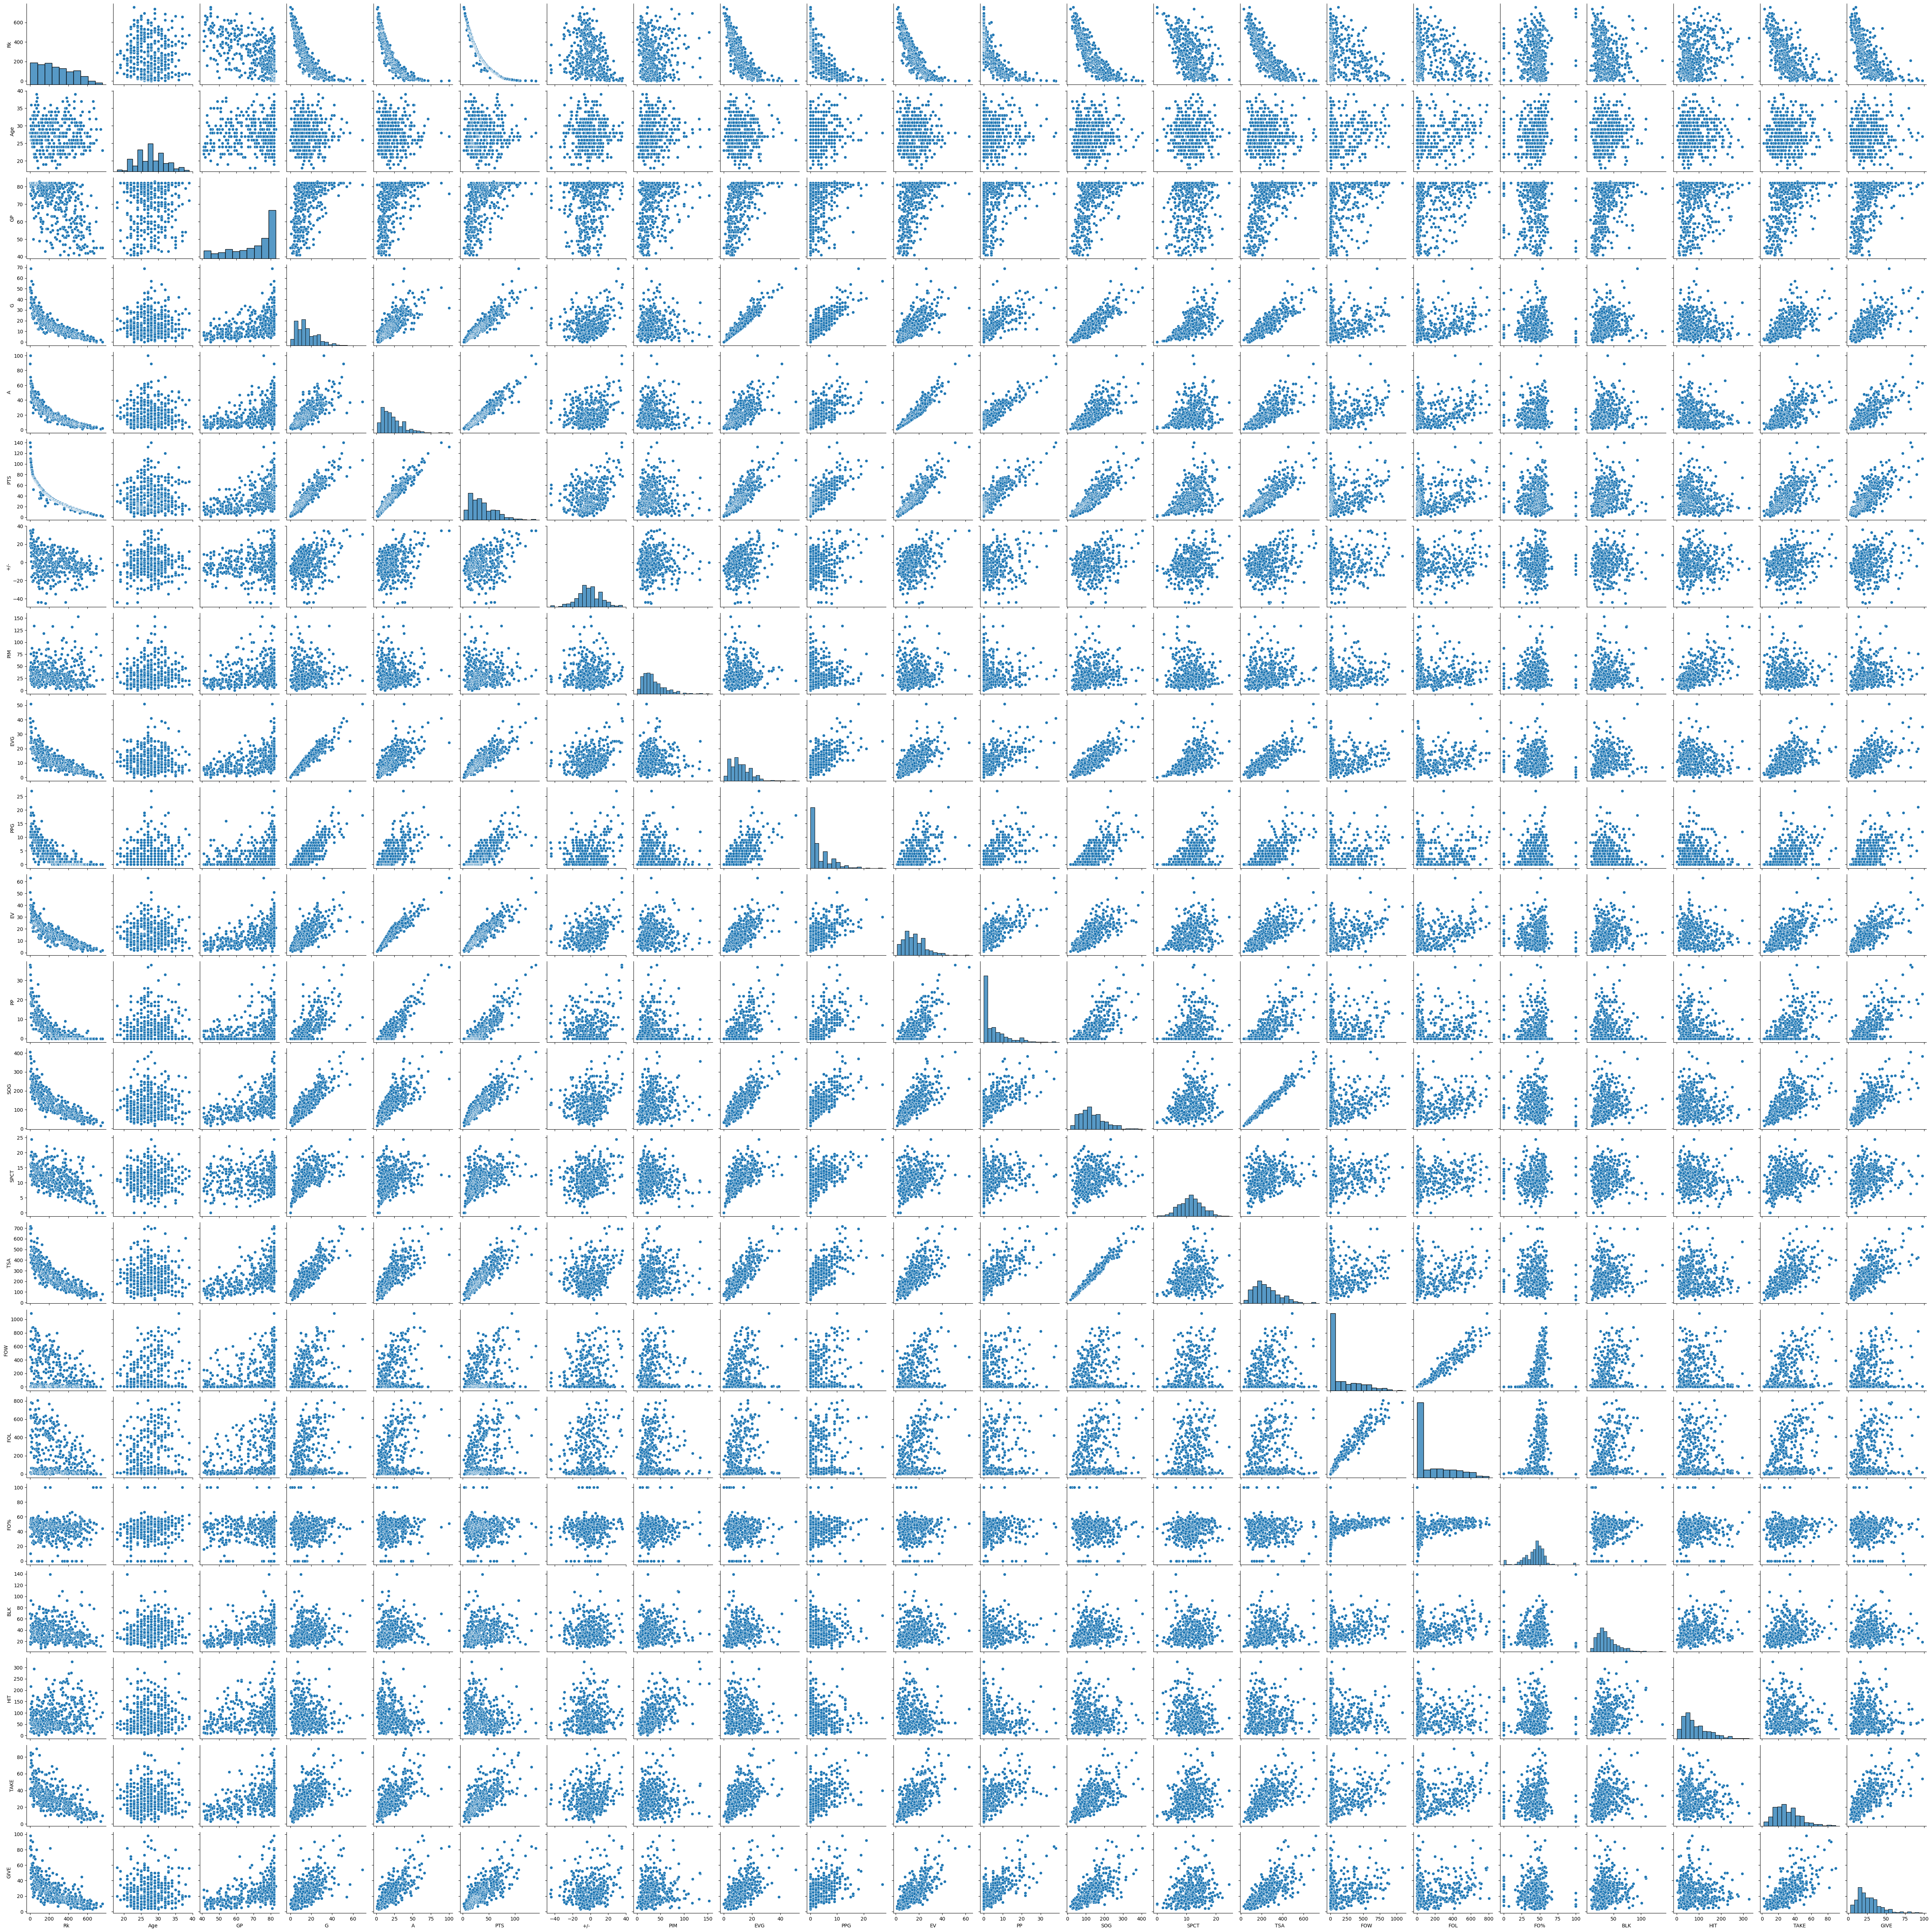

In [103]:
sns.pairplot(nhl)

EV (even strength assists) and TSA (total shots attempted) seemed to have many postive trends with the different varibles, so I wanted to use them to predict the total points of a player.

In [104]:
linear = torch.nn.Linear(in_features=2, # in_features: must match column number of input
                         out_features=1,# out_features: column number of output
                         dtype=torch.float64) #specifies the data type

X = s_tensor[:,[10,5]]
y_pred = linear(X) #the actual matrix multiplication
print(f"Input shape: {X.shape}\n")
print(f"Output:\n{y_pred}\n\nOutput shape: {y_pred.shape}")

Input shape: torch.Size([424, 2])

Output:
tensor([[81.9975],
        [80.0550],
        [69.0343],
        [64.3951],
        [60.2581],
        [63.2396],
        [60.5430],
        [60.0238],
        [56.8752],
        [54.9155],
        [55.9039],
        [53.6929],
        [54.2457],
        [51.6162],
        [51.8340],
        [52.5710],
        [52.2360],
        [51.7504],
        [51.4155],
        [49.4558],
        [45.8380],
        [47.1613],
        [48.2668],
        [43.2085],
        [44.4982],
        [47.0777],
        [45.4195],
        [30.7816],
        [43.4263],
        [46.5921],
        [45.1181],
        [43.2756],
        [42.9071],
        [44.7496],
        [42.9407],
        [43.3092],
        [42.2372],
        [42.4215],
        [43.0078],
        [43.7448],
        [41.9023],
        [41.5338],
        [41.4167],
        [42.3379],
        [40.3447],
        [40.1605],
        [39.0550],
        [40.1605],
        [41.0817],
        [39.6413],
       

In [105]:
X = s_tensor[:,[10]] #EV as a predictor
y = s_tensor[:,5].unsqueeze(dim=1) #PTS as estimand



# 80% of data is training, 20% is testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [106]:
#this function defaults to a random  offset vector and weight matrix
linear = torch.nn.Linear(
    in_features=1, # in_features: must match number of columns of input, which is now one
    out_features=1,# out_features: number of columns in output
    dtype=torch.float64) #specifies the data type

In [107]:
# Create a loss function
loss_fn = nn.MSELoss() # mean squared error; this is similar to multiplying our matrix by itself

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=linear.parameters(),
                            lr=0.1) #this is how fast it optimizes; smaller is slower, but more consistent

In [108]:
# Set the number of epochs; this is how many times we update our model
epochs = 10

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    linear.train()

    # 1. Forward pass; makes predictions
    y_pred = linear(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    linear.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = linear(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 1 == 0: #prints every 100 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 1212.12993, Test loss: 4603709.59444
Epoch: 1 | Train loss: 5086781.21284, Test loss: 21123652323.21344
Epoch: 2 | Train loss: 23358668368.81804, Test loss: 97003638341542.14062
Epoch: 3 | Train loss: 107265982416163.54688, Test loss: 445452996278112768.00000
Epoch: 4 | Train loss: 492579065443355776.00000, Test loss: 2045576950148150329344.00000
Epoch: 5 | Train loss: 2261985862134089646080.00000, Test loss: 9393550123376663383244800.00000
Epoch: 6 | Train loss: 10387327435219390622072832.00000, Test loss: 43136379649453797188768366592.00000
Epoch: 7 | Train loss: 47699931751414868114455658496.00000, Test loss: 198087754344349018647086311145472.00000
Epoch: 8 | Train loss: 219044167354832758482297295994880.00000, Test loss: 909644220030972763819284904179400704.00000
Epoch: 9 | Train loss: 1005878740083283112640486303680430080.00000, Test loss: 4177202219160619747782379002585885442048.00000


I noticed very high train loss scores which may mess up the plot. I wasn't quite sure yet so I went ahead and finished the plot prediction.

In [109]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

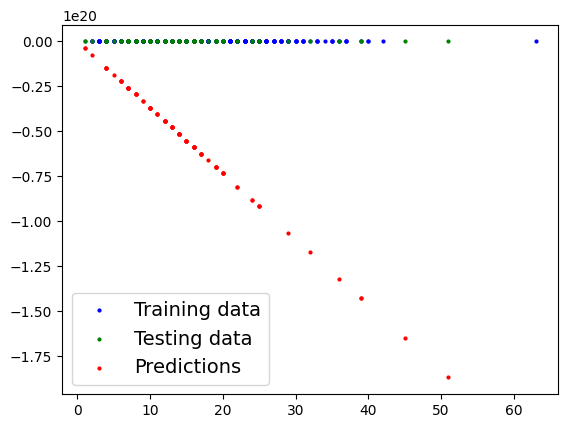

In [110]:
# Turn on evaluation mode
linear.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = linear(X_test)

# Plot data and predictions
plot_predictions(predictions=y_preds);

The plot looked very bad so I guessed that the problem was most likely the train loss scores. I looked up how to fix this and found that adding a scaler for my predictors and increasing the epochs may fix this.

In [111]:
linear = torch.nn.Linear(in_features=3, # input_features: column number of input
                         out_features=1,# out_features: column number of output
                         dtype=torch.float64) #specifies the data type

X = s_tensor[:,[10,5,14]] #u
y_pred = linear(X) #the actual matrix multiplication
print(f"Input shape: {X.shape}\n")
print(f"Output:\n{y_pred}\n\nOutput shape: {y_pred.shape}")

Input shape: torch.Size([424, 3])

Output:
tensor([[-388.2722],
        [-274.2487],
        [-358.9706],
        [-386.4931],
        [-372.2452],
        [-248.9448],
        [-293.2509],
        [-223.1755],
        [-316.0751],
        [-315.5406],
        [-273.0884],
        [-369.7428],
        [-251.3781],
        [-237.1710],
        [-227.9098],
        [-229.3516],
        [-274.8752],
        [-193.0744],
        [-211.0156],
        [-248.3485],
        [-265.3736],
        [-211.0577],
        [-230.9854],
        [-262.8540],
        [-186.6035],
        [-245.4122],
        [-241.4669],
        [-180.7889],
        [-235.3603],
        [-197.2714],
        [-280.4076],
        [-267.4531],
        [-239.6173],
        [-161.8769],
        [-277.9143],
        [-302.4777],
        [-221.2697],
        [-251.7838],
        [-179.1962],
        [-160.5355],
        [-266.7933],
        [-226.3350],
        [-141.0476],
        [-204.7935],
        [-268.8118],
        [-23

In [122]:
X = s_tensor[:,[10,14]] #use EV + TSA as a predictor
y = s_tensor[:,5].unsqueeze(dim=1) #PTS is the estimand
scaler = StandardScaler() #This makes the data more readable by the model
X = scaler.fit_transform(nhl.iloc[:, [10, 14]])
X = torch.from_numpy(X).double()



# 80% of data is training, 20% is testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [123]:
#this function defaults to a random  offset vector and weight matrix
linear = torch.nn.Linear(
    in_features=2, # This part took a bit of trial and error because the parameters for the in features is actually different from this line compared to the one above, something that I didn't really understand until my code gave me an error due to my dim of my matrixes being out of order
    out_features=1,# out_features: number of columns in output
    dtype=torch.float64) #specifies the data type


In [134]:
# Create a loss function
loss_fn = nn.MSELoss() # mean squared error; this is similar to multiplying our matrix by itself

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=linear.parameters(),
                            lr=0.1) #this is how fast it optimizes; smaller is slower, but more consistent

In [135]:
# Set the number of epochs; this is how many times we update our model
epochs = 100 #increased from 10 -> 100
for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    linear.train()

    # 1. Forward pass; makes predictions
    y_pred = linear(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    linear.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = linear(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 1 == 0: #prints every 100 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 43.60027, Test loss: 64.54964
Epoch: 1 | Train loss: 43.60026, Test loss: 64.54907
Epoch: 2 | Train loss: 43.60026, Test loss: 64.54854
Epoch: 3 | Train loss: 43.60026, Test loss: 64.54803
Epoch: 4 | Train loss: 43.60026, Test loss: 64.54755
Epoch: 5 | Train loss: 43.60026, Test loss: 64.54709
Epoch: 6 | Train loss: 43.60026, Test loss: 64.54666
Epoch: 7 | Train loss: 43.60026, Test loss: 64.54625
Epoch: 8 | Train loss: 43.60026, Test loss: 64.54586
Epoch: 9 | Train loss: 43.60026, Test loss: 64.54550
Epoch: 10 | Train loss: 43.60026, Test loss: 64.54515
Epoch: 11 | Train loss: 43.60026, Test loss: 64.54482
Epoch: 12 | Train loss: 43.60026, Test loss: 64.54451
Epoch: 13 | Train loss: 43.60026, Test loss: 64.54421
Epoch: 14 | Train loss: 43.60026, Test loss: 64.54393
Epoch: 15 | Train loss: 43.60026, Test loss: 64.54367
Epoch: 16 | Train loss: 43.60026, Test loss: 64.54342
Epoch: 17 | Train loss: 43.60026, Test loss: 64.54318
Epoch: 18 | Train loss: 43.60026, Test

The train loss scores were now looking much better so hopefully the model will graph something looking better.

In [136]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

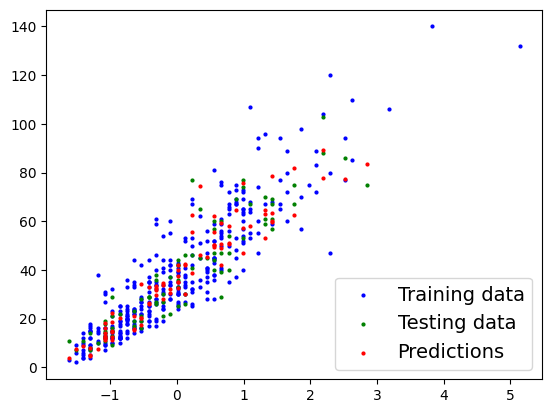

In [137]:
# Turn on evaluation mode
linear.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = linear(X_test)

# Select the first feature from X_test for plotting, I had to add this as just running as is was breaking it because we had incompatible dims between x and y
# Make sure to also select the corresponding feature from X_train for the training data plot
plot_predictions(train_data=X_train[:, [0]],
                 test_data=X_test[:, [0]], # Select the first feature from X_test
                 predictions=y_preds);


The graph looked much better and definitly showed that these variables could be used to predict player PTS values. Another variable that looked like it had some correlation was PPG (power play goals), so I added it in

In [138]:
linear = torch.nn.Linear(in_features=4, # input_features: column number of input
                         out_features=1,# out_features: column number of output
                         dtype=torch.float64) #specifies the data type

X = s_tensor[:,[10,5,14,9]] #u
y_pred = linear(X) #the actual matrix multiplication
print(f"Input shape: {X.shape}\n")
print(f"Output:\n{y_pred}\n\nOutput shape: {y_pred.shape}")

Input shape: torch.Size([424, 4])

Output:
tensor([[-128.2493],
        [ -69.2563],
        [-125.2337],
        [-145.6317],
        [-142.0171],
        [ -74.3194],
        [ -99.2290],
        [ -61.1721],
        [-114.7907],
        [-117.4470],
        [ -92.9745],
        [-147.0615],
        [ -84.9126],
        [ -77.8142],
        [ -72.2959],
        [ -72.9939],
        [ -96.9749],
        [ -53.8013],
        [ -63.9822],
        [ -85.6841],
        [ -99.4304],
        [ -67.2527],
        [ -77.4343],
        [ -99.9714],
        [ -57.4517],
        [ -87.7152],
        [ -85.5199],
        [ -67.4807],
        [ -84.2482],
        [ -60.9808],
        [-108.1508],
        [-101.3402],
        [ -88.5883],
        [ -43.3197],
        [-108.1222],
        [-121.7156],
        [ -79.2420],
        [ -94.8548],
        [ -54.6583],
        [ -44.1380],
        [-103.0596],
        [ -81.9982],
        [ -35.9135],
        [ -68.6308],
        [-106.1692],
        [ -8

In [139]:
X = s_tensor[:,[10,14,9]] #use EV + TSA + PPG as a predictor
y = s_tensor[:,5].unsqueeze(dim=1) #PTS is the estimand
scaler = StandardScaler() #This makes the data more readable by the model
X = scaler.fit_transform(nhl.iloc[:, [10, 14, 9]])
X = torch.from_numpy(X).double()



# 80% of data is training, 20% is testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [140]:
#this function defaults to a random  offset vector and weight matrix
linear = torch.nn.Linear(
    in_features=3, # in_features: must match number of columns of input, which is now one
    out_features=1,# out_features: number of columns in output
    dtype=torch.float64) #specifies the data type

In [141]:
# Create a loss function
loss_fn = nn.MSELoss() # mean squared error; this is similar to multiplying our matrix by itself

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=linear.parameters(),
                            lr=0.1) #this is how fast it optimizes; smaller is slower, but more consistent


In [146]:
# Set the number of epochs; this is how many times we update our model
epochs = 100
for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    linear.train()

    # 1. Forward pass; makes predictions
    y_pred = linear(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    linear.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = linear(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 1 == 0: #prints every 100 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")


Epoch: 0 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 1 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 2 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 3 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 4 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 5 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 6 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 7 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 8 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 9 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 10 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 11 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 12 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 13 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 14 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 15 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 16 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 17 | Train loss: 30.04377, Test loss: 27.02473
Epoch: 18 | Train loss: 30.04377, Test

Training losses were now even lower which was a good sisgn

In [143]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

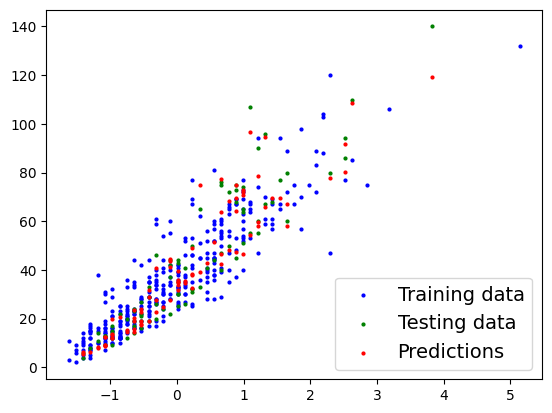

In [148]:
# Turn on evaluation mode
linear.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = linear(X_test)

# Select the first feature from X_test for plotting, I had to add this as just running as is was breaking it because we had incompatible dims between x and y
# Make sure to also select the corresponding feature from X_train for the training data plot
plot_predictions(train_data=X_train[:, [0]],
                 test_data=X_test[:, [0]], # Select the first feature from X_test
                 predictions=y_preds);

Didn't really look any different from the last graph but still was pretty good.